This section of the notebook is for loading the audio files, processing the labels and text features into
integers, and saving them in a Pandas DataFrame with .pkl format. The "dsl_data" folder should be placed next to this notebook if you wish to run it.

# WARNING: May take a long time to run.

In [1]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch import nn
import numpy as np
import librosa, librosa.display
from sklearn import preprocessing
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


torch.__version__

'1.12.0'

In [2]:
data_train = pd.read_csv('dsl_data\development.csv', dtype = 'string')
data_eval = pd.read_csv('dsl_data\evaluation.csv', dtype = 'string')

In [3]:
data_train.describe()

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
count,9854,9854,9854,9854,9854,9854,9854,9854,9854,9854
unique,9854,9854,87,5,5,4,5,4,2,3
top,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,R3mXwwoaX9IoRVKe,increase,volume,native,English (United States),English (United States),male,22-40
freq,1,1,183,3823,5000,9444,9642,9598,5265,7496


In [4]:
data_eval.describe()

,Id,path,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
count,1455,1455,1455,1455,1455,1455,1455,1455
unique,1455,1455,10,1,1,1,2,2
top,0,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53c...,7B4XmNppyrCK977p,native,English (United States),English (United States),female,22-40
freq,1,1,183,1455,1455,1455,773,907


In [7]:
label_enc = preprocessing.LabelEncoder()

audio_data = {}
audio_data['train'] = {}
audio_data['train']['audio'] = {}
audio_data['train']['label'] = {}
for i in tqdm(range(data_train.shape[0])):
    audio_train, sr = librosa.load(data_train['path'][i])
        
    audio_data['train']['audio'][i] = audio_train
    audio_data['train']['label'][i] = data_train.iloc[i]['action'] + data_train.iloc[i]['object']

100%|██████████████████████████████████████████████████████████████████████████████| 9854/9854 [06:21<00:00, 25.84it/s]


In [8]:
audio_data['eval'] = {}
audio_data['eval']['audio'] = {}
for i in tqdm(range(data_eval.shape[0])):
    audio_eval, sr = librosa.load(data_eval['path'][i])
    
    audio_data['eval']['audio'][i] = audio_eval

100%|██████████████████████████████████████████████████████████████████████████████| 1455/1455 [01:07<00:00, 21.55it/s]


In [9]:
audio_data_df = pd.DataFrame(audio_data)

train_df = pd.DataFrame(audio_data['train'])
evaluation_df = pd.DataFrame(audio_data['eval'])

In [10]:
label_encoder = preprocessing.LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(le_name_mapping)

{'activatemusic': 0, 'change languagenone': 1, 'deactivatelights': 2, 'decreaseheat': 3, 'decreasevolume': 4, 'increaseheat': 5, 'increasevolume': 6}


In [11]:
np.save('encoder_final.npy', label_encoder.classes_)

In [12]:
feature_encoder = preprocessing.LabelEncoder()
train_df['fluency'] = feature_encoder.fit_transform(data_train['Self-reported fluency level '])
train_df['first_lang'] = feature_encoder.fit_transform(data_train['First Language spoken'])
train_df['current_lang'] = feature_encoder.fit_transform(data_train['Current language used for work/school'])
train_df['gender'] = feature_encoder.fit_transform(data_train['gender'])
train_df['age_range'] = feature_encoder.fit_transform(data_train['ageRange'])

In [13]:
evaluation_df['fluency'] = feature_encoder.fit_transform(data_eval['Self-reported fluency level '])
evaluation_df['first_lang'] = feature_encoder.fit_transform(data_eval['First Language spoken'])
evaluation_df['current_lang'] = feature_encoder.fit_transform(data_eval['Current language used for work/school'])
evaluation_df['gender'] = feature_encoder.fit_transform(data_eval['gender'])
evaluation_df['age_range'] = feature_encoder.fit_transform(data_eval['ageRange'])

In [14]:
train_df

,audio,label,fluency,first_lang,current_lang,gender,age_range
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,1,2,0,0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,1,2,0,0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0,1,2,0,0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,0,1,2,0,0
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,0,1,2,0,0
...,...,...,...,...,...,...,...
9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",4,3,1,2,1,0
9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",2,3,1,2,1,0
9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",2,3,1,2,1,0
9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",2,3,1,2,1,0


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9854 entries, 0 to 9853
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   audio         9854 non-null   object
 1   label         9854 non-null   int32 
 2   fluency       9854 non-null   int32 
 3   first_lang    9854 non-null   int32 
 4   current_lang  9854 non-null   int32 
 5   gender        9854 non-null   int32 
 6   age_range     9854 non-null   int32 
dtypes: int32(6), object(1)
memory usage: 384.9+ KB


In [16]:
evaluation_df

,audio,fluency,first_lang,current_lang,gender,age_range
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,1,0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,1,0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,1,1
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,1,0
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,1
...,...,...,...,...,...,...
1450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0
1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0
1452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,1
1453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0


In [ ]:
train_df.iloc[:, 1:] = train_df.iloc[:, 1:].astype('float32')
evaluation_df.iloc[:, 1:] = evaluation_df.iloc[:, 1:].astype('float32')

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9854 entries, 0 to 9853
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   audio         9854 non-null   object 
 1   label         9854 non-null   float32
 2   fluency       9854 non-null   float32
 3   first_lang    9854 non-null   float32
 4   current_lang  9854 non-null   float32
 5   gender        9854 non-null   float32
 6   age_range     9854 non-null   float32
dtypes: float32(6), object(1)
memory usage: 384.9+ KB


In [19]:
evaluation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1454
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   audio         1455 non-null   object 
 1   fluency       1455 non-null   float32
 2   first_lang    1455 non-null   float32
 3   current_lang  1455 non-null   float32
 4   gender        1455 non-null   float32
 5   age_range     1455 non-null   float32
dtypes: float32(5), object(1)
memory usage: 51.2+ KB


In [20]:
train_df.to_pickle("train_audio_final.pkl")
evaluation_df.to_pickle("evaluation_audio_final.pkl")

This section loads the .pkl files and generates the mel spectrograms. Stores the results in another
separate .pkl file for developement and test. It has to be run twice, once for train audio and once for
evaluation audio. Uncomment the lines respectively.
# WARNING: May take a long time to run.

In [23]:
audio_data_df = pd.read_pickle('train_audio_final.pkl')
# audio_data_df = pd.read_pickle('evaluation_audio_final.pkl')

sr = 22050
top_db = 25
fmax = 8192

n_mels = 200
n_mfcc = 20
n_fft = 2048
hop_length = 32

label_enc = preprocessing.LabelEncoder()

audio_data = {}
audio_data['signal'] = {}
for i in tqdm(range(audio_data_df['audio'].shape[0])):
    y = audio_data_df['audio'][i]
    
    clipped_audio,_ = librosa.effects.trim(y, top_db= top_db)
    
    S = librosa.feature.melspectrogram(y=clipped_audio, sr=sr, n_mels=n_mels,
                                    fmax=fmax, n_fft=n_fft, hop_length=hop_length)
    S += 1e-9
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    audio_data['signal'][i] = S_dB.astype('float32')


audio_data_df_new = pd.DataFrame.from_dict(audio_data)
audio_data_df_new = audio_data_df_new.join(audio_data_df.iloc[:,1:])
print(audio_data_df_new.info())
audio_data_df_new.to_pickle("train_signal_final.pkl")
# audio_data_df_new.to_pickle("eval_signal_final.pkl")

100%|██████████████████████████████████████████████████████████████████████████████| 9854/9854 [06:11<00:00, 26.55it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9854 entries, 0 to 9853
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   signal        9854 non-null   object 
 1   label         9854 non-null   float32
 2   fluency       9854 non-null   float32
 3   first_lang    9854 non-null   float32
 4   current_lang  9854 non-null   float32
 5   gender        9854 non-null   float32
 6   age_range     9854 non-null   float32
dtypes: float32(6), object(1)
memory usage: 643.0+ KB
None


(200, 425)


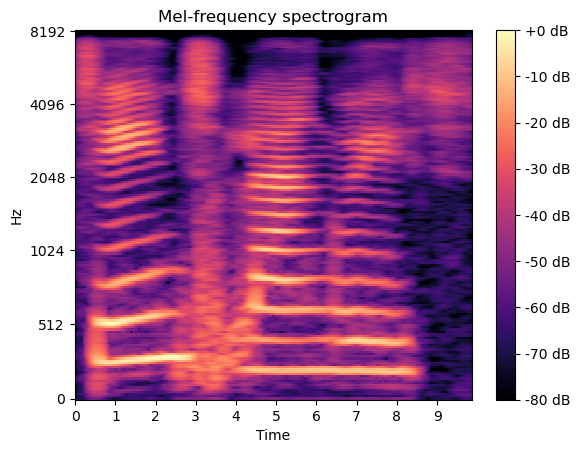

In [26]:
x = audio_data_df_new['signal'][0]

fig, ax = plt.subplots()
img = librosa.display.specshow(x, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=fmax, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

print(x.shape)

This section loads the preprocessed Mel spectrograms and trains the model on them. The model trains on the GPU using CUDA but the code is device agnostic. Be mindful however, on a CPU or weaker GPU it may take...
# A LONG TIME TO RUN.

In [3]:
train_df = pd.read_pickle('train_signal_final.pkl')
eval_df = pd.read_pickle('eval_signal_final.pkl')

In [4]:
print(train_df.info())
print(eval_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9854 entries, 0 to 9853
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   signal        9854 non-null   object 
 1   label         9854 non-null   float32
 2   fluency       9854 non-null   float32
 3   first_lang    9854 non-null   float32
 4   current_lang  9854 non-null   float32
 5   gender        9854 non-null   float32
 6   age_range     9854 non-null   float32
dtypes: float32(6), object(1)
memory usage: 384.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1454
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   signal        1455 non-null   object 
 1   fluency       1455 non-null   float32
 2   first_lang    1455 non-null   float32
 3   current_lang  1455 non-null   float32
 4   gender        1455 non-null   float32
 5   age_range     1455 non-null   float3

(200, 897)


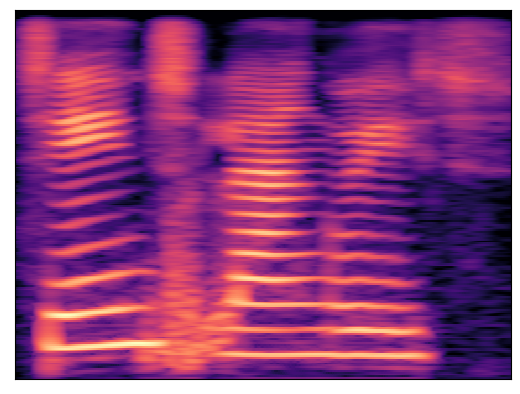

In [5]:
librosa.display.specshow(train_df['signal'][0])
print(train_df['signal'][0].shape)

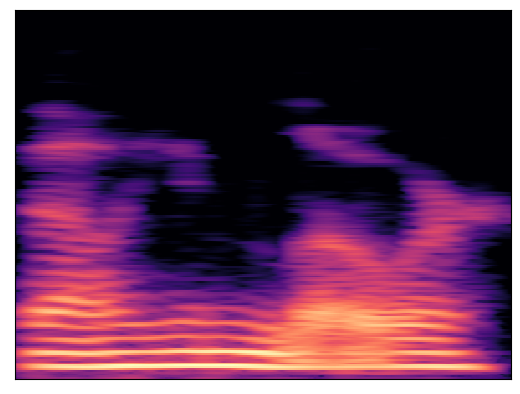

In [6]:
librosa.display.specshow(eval_df['signal'][0])

In [7]:
X_train = train_df['signal']
Y_train = train_df['label'].astype('float32')
X_test = eval_df['signal']

y_train = torch.from_numpy(Y_train.to_numpy()).type(torch.float32)

In [8]:
label_counts = np.bincount(y_train)
label_counts

array([ 791, 1113,  552, 1189, 2386, 1209, 2614], dtype=int64)

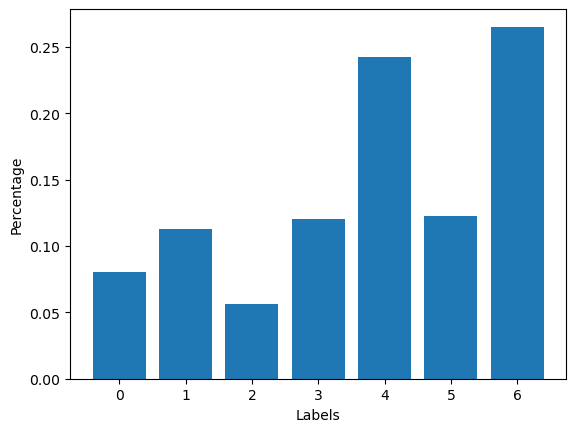

tensor([0.2653, 0.1227, 0.2421, 0.1207, 0.0560, 0.1129, 0.0803])

<Figure size 640x480 with 0 Axes>

In [9]:
label_counts = np.bincount(y_train)

label_perc = label_counts / np.sum(label_counts)
label_perc = torch.from_numpy(label_perc).type(torch.float32)

# Data to plot
labels = range(label_perc.shape[0])
values = label_perc
plt.bar(labels, values)
plt.xlabel('Labels')
plt.ylabel('Percentage')
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('bar_graph.png')

label_perc = torch.flip(label_perc, [0])
label_perc

In [10]:
def pad_sequence(batch):
    
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch


def collate_fn_train(batch):
    
    tensors, targets = [], []
    for x, y in batch:
        tensors += [x.T]
        targets += [y]
        
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


def collate_fn_test(batch):
    
    tensors = []
    for x in batch:
        tensors += [x.T]

    tensors = pad_sequence(tensors)

    return tensors


class AudioDataset_Train(Dataset):
    def __init__(self, X: pd.DataFrame, Y: pd.DataFrame):
        self.Y = Y
        self.X = X
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return  torch.from_numpy(self.X.iloc[idx]).type(torch.float32), self.Y[idx]

    
class AudioDataset_Test(Dataset):
    def __init__(self, X: pd.DataFrame):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return  torch.from_numpy(self.X.iloc[idx]).type(torch.float32)
    

def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

In [11]:
training_dataset = AudioDataset_Train(X_train, y_train)
test_dataset = AudioDataset_Test(X_test)
BATCH_SIZE = 8

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE,
                                              shuffle=True, drop_last=False, collate_fn=collate_fn_train)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                              shuffle=False, drop_last=False, collate_fn=collate_fn_test)

In [12]:
class CNN_LSTM(nn.Module):
    def __init__(self, n_input=200, n_output=7, stride=4, n_channel=400):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=5, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)

        self.lstm = nn.LSTM(input_size=n_channel , hidden_size = n_channel , num_layers= 1, batch_first=True)
        
        self.classifier = nn.Linear(n_channel, n_output)
        

    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x) 
        
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = x.permute(0, 2, 1)
        x,_ = self.lstm(x)
        x = F.relu(x[:,-1,:])

        x = self.classifier(x)
        
        return x

In [13]:
def train(dataloader: DataLoader, model):
    model.train()
    loss_train = 0
    correct = 0
    num_samples = 0
    
    with tqdm(dataloader, unit="batch") as tepoch:
        for x, y in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            
            x = x.to(device)
            y = y.type(torch.LongTensor)
            y = y.to(device)   

            out = model(x).squeeze()
        
            loss = loss_fn(out, y)
            loss_train += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            pred = get_likely_index(out)        
            correct += number_of_correct(pred, y)
            num_samples += x.shape[0]
            
            accuracy = correct/num_samples

            tepoch.set_postfix(loss=loss_train.item()/num_samples, accuracy = accuracy)
            
    scheduler.step()
    return model, loss_train.item()/num_samples
    
    
def test(dataloader: DataLoader, model):
    model.eval()
    model = model.to(device)
    loss = 0
    
    c_pred_list = torch.empty(0).to(device)
    with torch.inference_mode():
        with tqdm(dataloader, unit="batch") as tepoch:
            for x in tepoch:
                x = x.to(device)

                out = model(x).squeeze()
                c_pred = torch.argmax(out, dim = 1)
                
                c_pred_list = torch.cat((c_pred_list, c_pred))
    
    return c_pred_list

In [14]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
model = CNN_LSTM().to(device)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)
loss_fn = torch.nn.CrossEntropyLoss(weight=label_perc.to(device))

In [15]:
epochs = 100
for epoch in range(epochs):
    train(training_loader, model)

Epoch 99: 100%|████████████████████████████████████████| 1232/1232 [00:20<00:00, 59.83batch/s, accuracy=1, loss=6.9e-6]


In [16]:
from sklearn import preprocessing

eval_pred = test(test_loader, model).to('cpu')
encoder = preprocessing.LabelEncoder()
encoder.classes_ = np.load('encoder.npy', allow_pickle=True)

eval_pred_text = encoder.inverse_transform(eval_pred.to(torch.int32))
print(eval_pred_text)

data = {'Id': range(len(eval_pred_text)), 'Predicted': eval_pred_text}

df = pd.DataFrame(data)

print(df)


df.to_csv("submission_final.csv", index=False)

100%|█████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 48.30batch/s]


['decreasevolume' 'increaseheat' 'increaseheat' ... 'increaseheat'
 'decreaseheat' 'activatemusic']
        Id            Predicted
0        0       decreasevolume
1        1         increaseheat
2        2         increaseheat
3        3     deactivatelights
4        4       decreasevolume
...    ...                  ...
1450  1450  change languagenone
1451  1451       increasevolume
1452  1452         increaseheat
1453  1453         decreaseheat
1454  1454        activatemusic

[1455 rows x 2 columns]


In [17]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

MODEL_NAME = 'cnn_lstm_final.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model.state_dict(), MODEL_SAVE_PATH)